# Hospitalization Hypothesis Testing

## Content
* [Assignment](#assgnmt)
* [Preparation](#prep)
* [Exploration](#explr)
* [Viral load in regions](#vir_region)
    * [northeast](#northeast)
    * [northwest](#northwest)
    * [southeast](#southeast)
    * [southwest](#southwest)
* [Impact on hospitalization charges](#hosp_impact)


## Assignment <a id="assgnmt"></a>
Apollo Hospitals renowned as the architect of modern healthcare in India.\
They collected data of COVID-19 hospital patients and want to know:
- which variables are significant in predicting the viral load for different regions;
- how well some variables like viral load, smoking, and severity level describe the hospitalization charges;

For this, one dataset is given:
- `apollo_data.csv` - contains anonymized data of COVID-19 hospital patients and contains the [following variables](apollo_dataset_info.txt) (click on link).

## Preparation <a id="prep"></a>

In [1]:
#Import libraries and dataset
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('apollo_data.csv')

In [2]:
#Understand types of data in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1338 non-null   int64  
 1   age                      1338 non-null   int64  
 2   sex                      1338 non-null   object 
 3   smoker                   1338 non-null   object 
 4   region                   1338 non-null   object 
 5   viral load               1338 non-null   float64
 6   severity level           1338 non-null   int64  
 7   hospitalization charges  1338 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 83.8+ KB


In [3]:
#Understand columns content
data.head()

,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314
2,2,28,male,no,southeast,11.00,3,11124
3,3,33,male,no,northwest,7.57,0,54961
4,4,32,male,no,northwest,9.63,0,9667


In [4]:
#Drop tech. column
data.drop(columns='Unnamed: 0', inplace=True)

In [5]:
#Raname columns to remove spaces
data = data.rename(columns={'viral load': 'viral_load',
                            'age category': 'age_category',
                            'severity level': 'severity_level',
                            'hospitalization charges': 'hospitalization_charges'})

In [71]:
#Check nulls
data.isna().sum()

age                        0
sex                        0
smoker                     0
region                     0
viral_load                 0
severity_level             0
hospitalization_charges    0
age_category               0
dtype: int64

## Exploration <a id="explr"></a>

In [6]:
#Understand basic statistics and outliers
data.describe()

,age,viral_load,severity_level,hospitalization_charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,10.221233,1.094918,33176.058296
std,14.049960,2.032796,1.205493,30275.029296
min,18.000000,5.320000,0.000000,2805.000000
25%,27.000000,8.762500,0.000000,11851.000000
50%,39.000000,10.130000,1.000000,23455.000000
75%,51.000000,11.567500,2.000000,41599.500000
max,64.000000,17.710000,5.000000,159426.000000


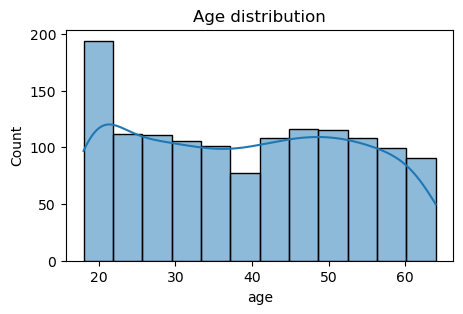

In [7]:
#Understand distribution of 'age' variable
plt.figure(figsize=(5,3))
sns.histplot(data['age'], kde=True)
plt.title('Age distribution')

plt.show()

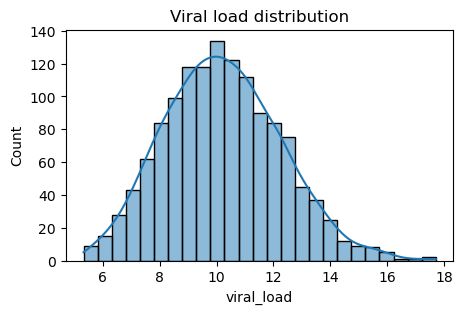

In [8]:
#Understand distribution of 'viral_load' variable
plt.figure(figsize=(5,3))
sns.histplot(data['viral_load'], kde=True)
plt.title('Viral load distribution')

plt.show()

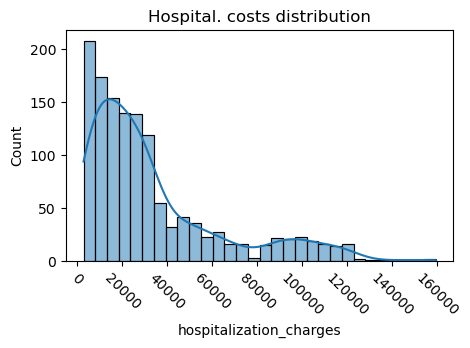

In [9]:
#Understand distribution of 'hospitalization_charges' variable
plt.figure(figsize=(5,3))
sns.histplot(data['hospitalization_charges'], kde=True)
plt.xticks(rotation = -45)
plt.title('Hospital. costs distribution')

plt.show()

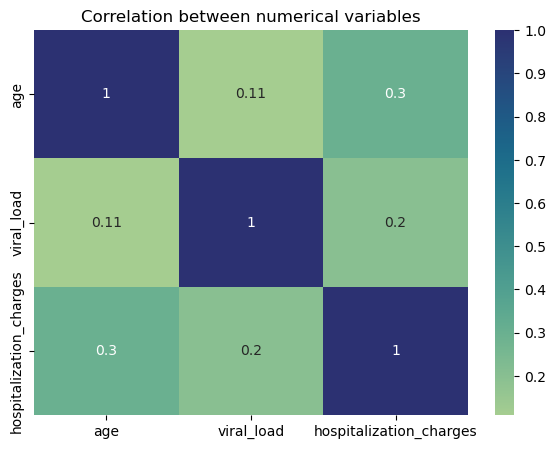

In [10]:
#Buid heatmap to observe correlation between numerical variables
numeric_var = data[['age', 'viral_load', 'hospitalization_charges']]

plt.figure(figsize=(7,5))
sns.heatmap(numeric_var.corr(), cmap = sns.color_palette('crest', as_cmap=True), annot = True)
plt.title('Correlation between numerical variables')

plt.show()

According to the plot above, there is slight correlation between dependent variable 'hospitalization_charges' and independent ones: 'age', 'viral_load'.

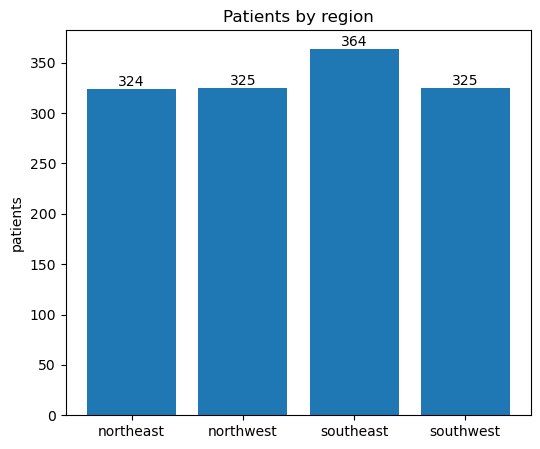

In [11]:
#Group data by region
region = data.groupby('region').size().reset_index(name='count')

#Build bar plot to compare number of patients
plt.figure(figsize=(6,5))
plt.bar(region['region'], region['count'])

for i, value in enumerate(region['count']): #Bars annotation
    plt.annotate(str(value), (region['region'][i], value), ha='center', va='bottom')

plt.ylabel('patients')
plt.title('Patients by region')

plt.show()

Based on chart above, Southeast region has more COVID cases than others. In other regions this number is equal.

In [12]:
#Bulid pivot table severity level by region
cross_tab = pd.crosstab(index=data['region'],
                             columns=data['severity_level'])

cross_tab

severity_level,0,1,2,3,4,5
region,,,,,,
northeast,147,77,51,39,7,3
northwest,132,74,66,46,6,1
southeast,157,95,66,35,5,6
southwest,138,78,57,37,7,8


Number of patients with certain severity level verise in different regions.\
However most patients have asymptomatic level (0) in each region.\
Below I built bar chart which help to recognize difference in proportions.

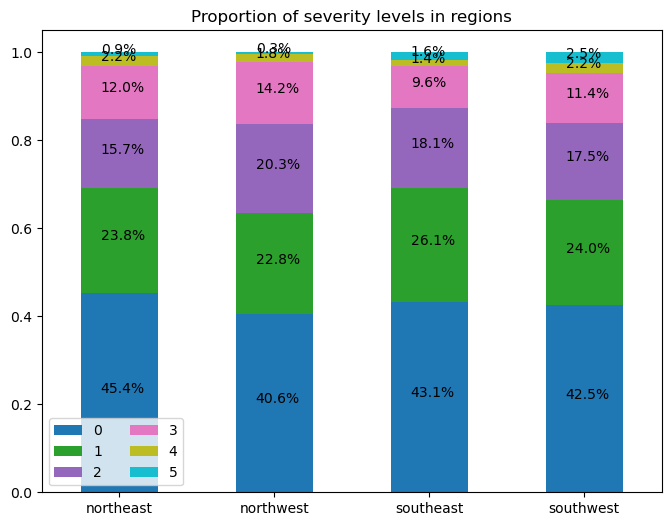

In [13]:
#Built visualization proportions of different severity level

#Create pivot with proportion
cross_tab_prop = pd.crosstab(index=data['region'],
                             columns=data['severity_level'],
                             normalize='index')

#Stucked chart
cross_tab_prop.plot(kind='bar', 
                        stacked=True, 
                        colormap='tab10', 
                        figsize=(8, 6))

#Bars annotation
for n, x in enumerate([*cross_tab.index.values]): 
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.12,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color='black',
                 fontsize=10)
        
plt.legend(loc='lower left', ncol=2)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.title('Proportion of severity levels in regions') 

plt.show()

According to the plot above, the biggets % of level 0 patients is within Northeast region. However this region has the lowest % of light level patients (1-2 level) and it is 2nd in hightest percent of level 3 patients (12%).\
Southeast region has the biggest proportion of light level patients (44.2%) and the lowest % of medium-hard patients (12.6%).\
Southwest region ranks 1st in the % of medium-hard patients (16.3%).


In [14]:
#Function to split patients into age groups
def age_class(age):
    if (age >= 18)&(age <= 29):
        return '18-29'
    if (age >= 30)&(age <= 39):
        return '30-39'
    if (age >= 40)&(age <= 49):
        return '40-49'
    else:
        return '50-64'

#Add column 'age_category'
data['age_category'] = data.age.apply(age_class)

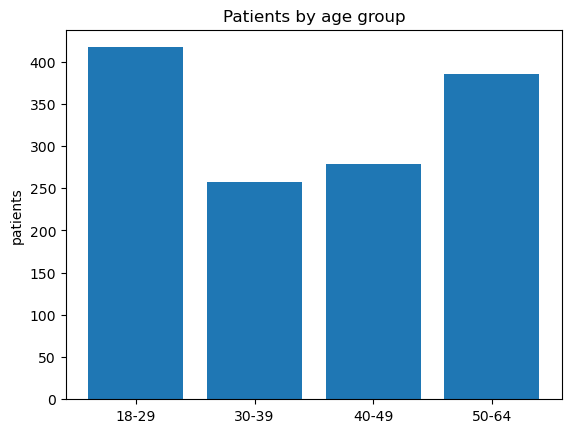

In [15]:
#Group patients by age category
age_groups = data.groupby('age_category').size().reset_index(name='count')

#Bulid bar plot based on grouped table
plt.bar(age_groups['age_category'], age_groups['count'])
plt.ylabel('patients')
plt.title('Patients by age group')

plt.show()

Most common age group is 18-29 and 50-64 being the next common one.

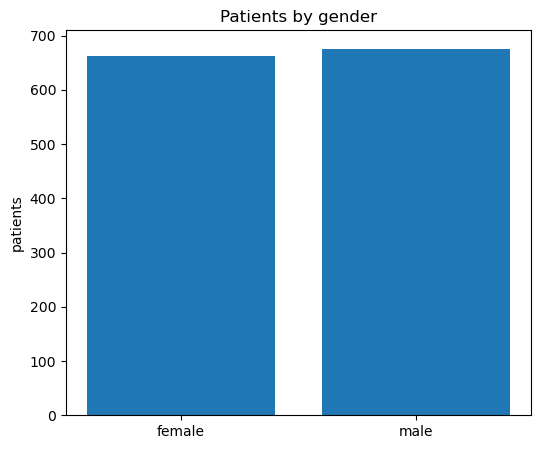

In [16]:
#Group rows by gender
genders = data.groupby('sex').size().reset_index(name='count')

#Bulid bar plot based on grouped table
plt.figure(figsize=(6,5))
plt.bar(genders['sex'], genders['count'])
plt.ylabel('patients')
plt.title('Patients by gender')

plt.show()

Number of female patients is almost the same as number of male patienst.

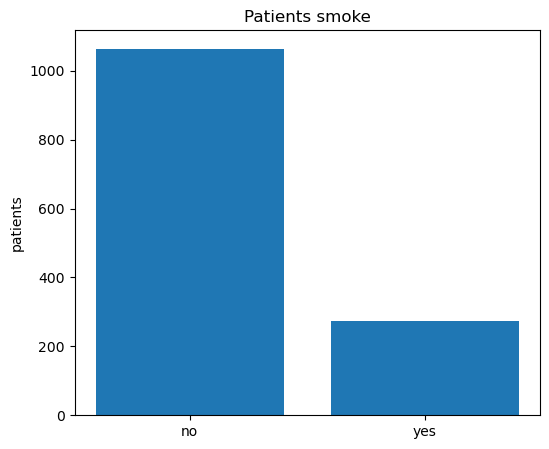

In [17]:
#Group rows by 'smoker' field
smok = data.groupby('smoker').size().reset_index(name='count')

#Bulid bar plot based on grouped table
plt.figure(figsize=(6,5))
plt.bar(smok['smoker'], smok['count'])
plt.ylabel('patients')
plt.title('Patients smoke')

plt.show()

## Viral load in regions <a id="vir_region"></a>
In this section I explored what independent variables significantly influence on viral load in 4 regions.

In [18]:
#Find viral load mean for each region
data.groupby('region')['viral_load'].mean().reset_index()

,region,viral_load
0,northeast,9.724722
1,northwest,9.733508
2,southeast,11.118516
3,southwest,10.198985


Based on table, there is quite big difference in Southwest and Southeast regions, and slight difference between Northeast and Northwest regions.


To check how significant difference between regions use 1-way ANOVA.\
But before we must be sure that our data meets following conditions:
- data must be normally distributed;
- variance in each group must be equal.

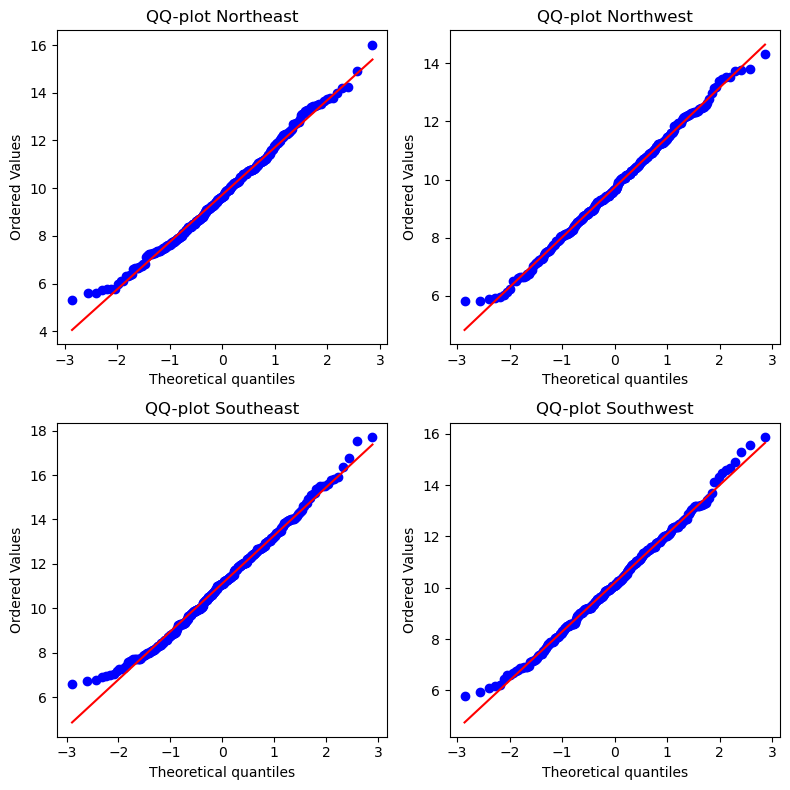

In [19]:
#Check distributions in terms of normality

#Devide groups by region in different sets
northeast = data[data.region == 'northeast'].reset_index(drop=True)
northwest = data[data.region == 'northwest'].reset_index(drop=True)
southeast = data[data.region == 'southeast'].reset_index(drop=True)
southwest = data[data.region == 'southwest'].reset_index(drop=True)

#Visualize distributions by building QQ-plots
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)

stats.probplot(northeast['viral_load'], dist='norm', plot=plt)
plt.title('QQ-plot Northeast')

plt.subplot(2, 2, 2)
stats.probplot(northwest['viral_load'], dist='norm', plot=plt)
plt.title('QQ-plot Northwest')

plt.subplot(2, 2, 3)
stats.probplot(southeast['viral_load'], dist='norm', plot=plt)
plt.title('QQ-plot Southeast')

plt.subplot(2, 2, 4)
stats.probplot(southwest['viral_load'], dist='norm', plot=plt)
plt.title('QQ-plot Southwest')

plt.tight_layout()
plt.show()

As it shown on plots above, all groups are normally distributed (most data points lies on normal line).

In [20]:
#Check homoscedasticity using Levene's Test
stats.levene(northeast['viral_load'], northwest['viral_load'], southeast['viral_load'], southwest['viral_load'])

LeveneResult(statistic=6.184842373736755, pvalue=0.0003579587785752236)

p-values < 0.05, means that variance between groups are different.\
Despite that we still can perform ANOVA duet to ANOVA is rule-breaking resistant if samples are quite big (>50).

In [21]:
#Perfrom 1-way ANOVA
stats.f_oneway(northeast['viral_load'], northwest['viral_load'], southeast['viral_load'], southwest['viral_load'])

F_onewayResult(statistic=39.46870879747586, pvalue=1.9508165724451252e-24)

p-value < 0.05 - reject null hypothesis. There is significant difference between at least two groups.\
To check which pairs are different I will use Tukey HSD test.

In [22]:
#Union 'viral_load' values in one set
group_values = np.concatenate([northeast['viral_load'], northwest['viral_load'],
                               southeast['viral_load'], southwest['viral_load']])

#Add labels
group_labels = ['northeast'] * northeast.shape[0] + ['northwest'] * northwest.shape[0] \
               + ['southeast'] * southeast.shape[0] + ['southwest'] * southwest.shape[0]

#Perfrom Tukey HSD test
tukey_res = pairwise_tukeyhsd(group_values, group_labels, alpha=0.05)
print(tukey_res)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
northeast northwest   0.0088 0.9999 -0.3851  0.4026  False
northeast southeast   1.3938    0.0  1.0106   1.777   True
northeast southwest   0.4743 0.0107  0.0804  0.8681   True
northwest southeast    1.385    0.0  1.0021  1.7679   True
northwest southwest   0.4655 0.0128  0.0719   0.859   True
southeast southwest  -0.9195    0.0 -1.3024 -0.5367   True
----------------------------------------------------------


Based on test results above, all group are different from each other except Northeast and Northwest.
p-values of northeast-northwest pair is almost 1, means these groups belong to one population.

### Viral load: Northeast <a id="northeast"></a>
In this section I applied multi-factor ANOVA to determine which below factor influence on viral load in Northeast region.\
Factors (independent variables):
- sex
- age_category
- smoker

In [23]:
#Build summary table grouped by factors
northeast_summary = northeast.groupby(['age_category', 'sex', 'smoker'])\
    .agg({'age': 'count', 'viral_load': ['mean', 'std']}).reset_index()

#Rename columns after grouping
northeast_summary.columns = ['age_category', 'sex', 'smoker', 'count', 'mean_viral_load', 'std_viral_load']

northeast_summary

,age_category,sex,smoker,count,mean_viral_load,std_viral_load
0,18-29,female,no,39,9.904359,1.923065
1,18-29,female,yes,9,8.227778,2.940888
2,18-29,male,no,41,9.067805,1.679638
3,18-29,male,yes,12,9.205000,1.645216
4,30-39,female,no,25,8.715200,1.963102
5,30-39,female,yes,6,9.463333,2.207674
6,30-39,male,no,21,9.979524,2.208405
7,30-39,male,yes,9,10.492222,1.850640
8,40-49,female,no,26,10.626154,2.063143
9,40-49,female,yes,8,8.437500,1.653928


To automate distribution normality check (Shapiro-Wilk test) for each group (table above), I built the following function:

In [24]:
#Shapiro-Wilk Normality Test function
def normality_test(summary_table, base_table):
    groups = []

    for _, row in summary_table.iterrows():
        subgroup = [row['age_category'], row['sex'], row['smoker']]
        groups.append(subgroup)

    for filters in groups:

        _, p_value = stats.shapiro(base_table[(base_table['age_category']==filters[0])
                            &(base_table['sex']==filters[1])
                            &(base_table['smoker']==filters[2])]['viral_load'].tolist())

        print(p_value) #return p-value of test

In [25]:
#Run function
normality_test(northeast_summary, northeast)

0.2789803147315979
0.003642398165538907
0.6972071528434753
0.23672223091125488
0.11754925549030304
0.9514960646629333
0.7227326035499573
0.5791453123092651
0.345513254404068
0.2647213339805603
0.21626004576683044
0.38154515624046326
0.8201383948326111
0.048468947410583496
0.9294612407684326
0.8280491232872009


According to above results, the following groups aren't distributed normally (p<0.05) due to outliers:
- 18-29 female smokers
- 50-64 female smokers

In [26]:
#Create condition for each group to drop outliers further

#50-64 female smokers outliers
ne_1 = (northeast['age_category'] == '50-64') \
          & (northeast['sex'] == 'female') \
          & (northeast['smoker'] == 'yes') \
          & (northeast['viral_load'] < 11)

#18-29 female smokers outliers
ne_2 = (northeast['age_category'] == '18-29') \
          & (northeast['sex'] == 'female') \
          & (northeast['smoker'] == 'yes') \
          & ((northeast['viral_load'] > 12) | (northeast['viral_load'] < 7))

#Drop rows according to the conditions and create new DataFrame
northeast_adj = northeast.drop(northeast[ne_1 | ne_2].index)

In [27]:
#Cunduct normality test again
#50-64 female smoker group
ne_1_adj = stats.shapiro(northeast_adj[(northeast_adj['age_category'] == '50-64')
                                         & (northeast_adj['sex'] == 'female')
                                         & (northeast_adj['smoker'] == 'yes')]['viral_load'])

#18-29 female smoker group
ne_2_adj = stats.shapiro(northeast_adj[(northeast_adj['age_category'] == '18-29')
                                         & (northeast_adj['sex'] == 'female')
                                         & (northeast_adj['smoker'] == 'yes')]['viral_load'])

print('Test results after adjustment: ')
print(f'Group 1: {ne_1_adj}')
print(f'Group 2: {ne_2_adj}')

Test results after adjustment: 
Group 1: ShapiroResult(statistic=0.8670248985290527, pvalue=0.28617432713508606)
Group 2: ShapiroResult(statistic=0.8633691072463989, pvalue=0.27245327830314636)


p-value > 0.05, means data is distributed normally.

To automate homoscedasticity check (Levene's test) for each group (table above), I built the following function:

In [28]:
#Homoscedasticity using Levene's Test function
def homos_test(summary_table, base_table):
    groups = []
    arrays = []

    for _, row in summary_table.iterrows():
        subgroup = [row['age_category'], row['sex'], row['smoker']]
        groups.append(subgroup)

    for filters in groups:
        array = base_table[(base_table['age_category']==filters[0])
                            &(base_table['sex']==filters[1])
                            &(base_table['smoker']==filters[2])]['viral_load'].tolist()

        arrays.append(array)

    p_value = stats.levene(*arrays)

    return  p_value

In [29]:
homos_test(northeast_summary, northeast_adj)

LeveneResult(statistic=0.9473929287487003, pvalue=0.5117015405804902)

p-value > 0.05, means terms about homoscedasticity are met. Now, I can perform multivariate ANOVA.

In [30]:
#Perform multi-factor ANOVA
model_northeast = ols('''viral_load ~ C(age_category) + C(sex) + C(smoker) +
                         C(age_category):C(sex) + C(age_category):C(smoker) + C(sex):C(smoker) +
                         C(age_category):C(sex):C(smoker)''', data=northeast_adj).fit()

sm.stats.anova_lm(model_northeast, typ=2)

,sum_sq,df,F,PR(>F)
C(age_category),41.834568,3.0,4.027336,0.007859
C(sex),1.536414,1.0,0.443723,0.505841
C(smoker),1.080156,1.0,0.311954,0.576899
C(age_category):C(sex),31.386805,3.0,3.021550,0.030023
C(age_category):C(smoker),22.989978,3.0,2.213203,0.086625
C(sex):C(smoker),6.802954,1.0,1.964723,0.162039
C(age_category):C(sex):C(smoker),39.686207,3.0,3.820518,0.010365
Residual,1042.227760,301.0,NaN,NaN


According to the test results, factor 'age_category' influence most significantly on 'viral_load', as well as interaction of 'age_category' and 'sex' factors; and interaction of all factors ('age_category', 'sex', 'smoker')

In [31]:
#Built function to create confidence interval visualization
def plot_conf_interval(x, values, z=1.96, hor_line_width=0.1):
    std = np.std(values)
    mean = np.mean(values)
    n = len(values)

    conf_intrval = z * (std / np.sqrt(n)) #standart error

    top = mean - conf_intrval #upper border
    bottom = mean + conf_intrval #lower border

    left = x - hor_line_width / 1.5 #left line length
    right = x + hor_line_width / 1.5 #right line length

    plt.plot([x, x], [top, bottom], color='blue')
    plt.plot([left, right], [top, top], color='blue')
    plt.plot([left, right], [bottom, bottom], color='blue')
    plt.plot(x, mean, 'o', color='red')

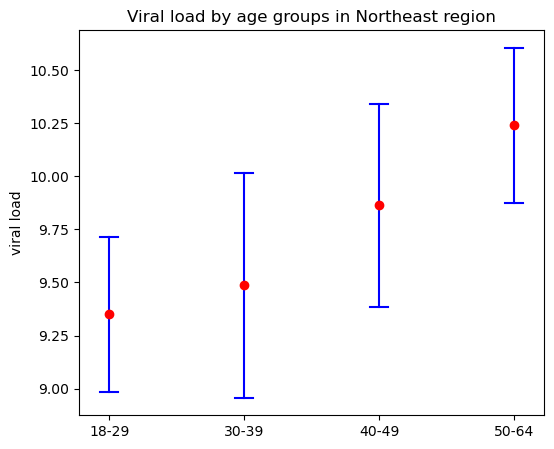

In [32]:
#Create confidence interval plot for factor 'age_category'
plt.figure(figsize=(6,5))
ax = plt.subplot()

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['18-29', '30-39', '40-49', '50-64'])

plot_conf_interval(1, northeast_adj[northeast_adj['age_category']=='18-29']['viral_load'])
plot_conf_interval(2, northeast_adj[northeast_adj['age_category']=='30-39']['viral_load'])
plot_conf_interval(3, northeast_adj[northeast_adj['age_category']=='40-49']['viral_load'])
plot_conf_interval(4, northeast_adj[northeast_adj['age_category']=='50-64']['viral_load'])

plt.ylabel('viral load')
plt.title('Viral load by age groups in Northeast region')

plt.show()

Based on plot, older people have a higher level of the viral load in Northeast region.

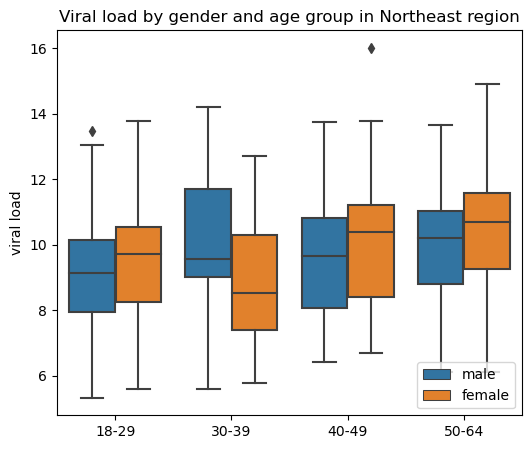

In [33]:
#Visualize influence factors

#Create sorted values for x-axis
plt.figure(figsize=(6,5))
sorted_categories = northeast_adj['age_category'].sort_values().unique()

sns.boxplot(x="age_category", y="viral_load",
            hue='sex', data=northeast_adj, order=sorted_categories)

plt.ylabel('viral load')
plt.xlabel('')
plt.title('Viral load by gender and age group in Northeast region')
plt.legend(loc='lower right')

plt.show()

### Viral load: Northwest <a id="northwest"></a>
In this section I applied multi-factor ANOVA to determine which factor influence on viral load in Northwest region.\
Factors (independent variables):
- sex
- age_category
- smoker

In [34]:
#Create condition for each group to further drop outliers
northwest_summary = northwest.groupby(['age_category', 'sex', 'smoker'])\
    .agg({'age': 'count', 'viral_load': ['mean', 'std']}).reset_index()

#Rename columns after grouping
northwest_summary.columns = ['age_category', 'sex', 'smoker', 'count', 'mean_viral_load', 'std_viral_load']

northwest_summary

,age_category,sex,smoker,count,mean_viral_load,std_viral_load
0,18-29,female,no,43,9.679767,1.825206
1,18-29,female,yes,8,9.203750,1.405153
2,18-29,male,no,43,9.314419,1.719350
3,18-29,male,yes,8,10.011250,1.497192
4,30-39,female,no,24,9.837083,2.008492
5,30-39,female,yes,6,9.405000,2.221592
6,30-39,male,no,28,9.149643,1.454557
7,30-39,male,yes,5,9.466000,1.350030
8,40-49,female,no,26,10.278077,1.820875
9,40-49,female,yes,8,9.655000,1.662846


In [35]:
#Apply Normality Test function (which created above)
normality_test(northwest_summary, northwest)

0.2017231285572052
0.14289923012256622
0.1027882918715477
0.6095420718193054
0.8475217819213867
0.7588280439376831
0.9333620071411133
0.5456709265708923
0.7720910310745239
0.28698158264160156
0.521819531917572
0.6008535027503967
0.3600628674030304
0.40648889541625977
0.6263872385025024
0.8853344321250916


According to the results of Shapiro-Wilk test, all groups are normally distributed.

In [36]:
#Apply Homoscedasticity Test function (which created above)
homos_test(northwest_summary, northwest)

LeveneResult(statistic=0.6731774610051009, pvalue=0.8106049027518927)

p-value > 0.05, means terms about homoscedasticity are met. Now, we can perform multi-factor ANOVA.

In [37]:
#Perform multi-factor ANOVA
model_northwest = ols('''viral_load ~ C(age_category) + C(sex) + C(smoker) +
                         C(age_category):C(sex) + C(age_category):C(smoker) + C(sex):C(smoker) +
                         C(age_category):C(sex):C(smoker)''', data=northwest).fit()

sm.stats.anova_lm(model_northwest, typ=2)

,sum_sq,df,F,PR(>F)
C(age_category),20.149536,3.0,2.283500,0.079020
C(sex),0.126530,1.0,0.043018,0.835828
C(smoker),0.308193,1.0,0.104780,0.746386
C(age_category):C(sex),11.758620,3.0,1.332577,0.263795
C(age_category):C(smoker),0.883037,3.0,0.100073,0.959924
C(sex):C(smoker),6.227830,1.0,2.117356,0.146653
C(age_category):C(sex):C(smoker),1.456990,3.0,0.165117,0.919823
Residual,908.868894,309.0,NaN,NaN


Based on the results, neither factors nor their interaction don't influence significantly on viral load.\
I can assume that there is some another independent variable which isn't included in the dataset but have influence on.

### Viral load: Southeast <a id="southeast"></a>
In this section I applied multi-factor ANOVA to determine which factor influence on viral load in Southeast region.\
Factors (independent variables):
- sex
- age_category
- smoker

In [38]:
#Create condition for each group to further drop outliers
southeast_summary = southeast.groupby(['age_category', 'sex', 'smoker'])\
    .agg({'age': 'count', 'viral_load': ['mean', 'std']}).reset_index()

#Rename columns after grouping
southeast_summary.columns = ['age_category', 'sex', 'smoker', 'count', 'mean_viral_load', 'std_viral_load']

southeast_summary

,age_category,sex,smoker,count,mean_viral_load,std_viral_load
0,18-29,female,no,42,10.922857,1.857314
1,18-29,female,yes,12,10.328333,1.806880
2,18-29,male,no,45,11.144667,2.271771
3,18-29,male,yes,16,12.008125,2.554322
4,30-39,female,no,30,10.751667,2.041661
5,30-39,female,yes,4,11.020000,2.200788
6,30-39,male,no,25,11.926000,2.146534
7,30-39,male,yes,10,10.828000,1.662219
8,40-49,female,no,28,10.770357,1.691844
9,40-49,female,yes,10,11.559000,2.610213


In [39]:
#Apply Normality Test function (which created above)
normality_test(southeast_summary, southeast)

0.1434975415468216
0.4543911814689636
0.04584521800279617
0.8016905188560486
0.02667073905467987
0.14767146110534668
0.6923013925552368
0.15986338257789612
0.08599065244197845
0.9286745190620422
0.2621244490146637
0.15962836146354675
0.198849618434906
0.2976115345954895
0.7386855483055115
0.1126856803894043


In [40]:
#Create condition for each group to further drop outliers

#18-29 male not smoker outliers
se_1 = (southeast['age_category'] == '18-29') \
          & (southeast['sex'] == 'male') \
          & (southeast['smoker'] == 'no') \
          & (southeast['viral_load'] > 17)

#30-39 female not smoker outliers
se_2 = (southeast['age_category'] == '30-39') \
          & (southeast['sex'] == 'female') \
          & (southeast['smoker'] == 'no') \
          & (southeast['viral_load'] > 14)

#Drop rows according to the conditions and create new DataFrame
southeast_adj = southeast.drop(southeast[se_1 | se_2].index)

In [41]:
#18-29 male no smoker group
se_1_adj = stats.shapiro(southeast_adj[(southeast_adj['age_category'] == '18-29')
                                         & (southeast_adj['sex'] == 'male')
                                         & (southeast_adj['smoker'] == 'no')]['viral_load'])

#30-39 female no smoker group
se_2_adj = stats.shapiro(southeast_adj[(southeast_adj['age_category'] == '30-39')
                                         & (southeast_adj['sex'] == 'female')
                                         & (southeast_adj['smoker'] == 'no')]['viral_load'])

print('Test results after adjustment: ')
print(f'Group 1: {se_1_adj}')
print(f'Group 2: {se_2_adj}')

Test results after adjustment: 
Group 1: ShapiroResult(statistic=0.9662190675735474, pvalue=0.2212287187576294)
Group 2: ShapiroResult(statistic=0.9358788132667542, pvalue=0.09641377627849579)


p > 0.05, means data is normally distributed now.

In [42]:
#Apply Homoscedasticity Test function (which created above)
homos_test(southeast_summary, southeast_adj)

LeveneResult(statistic=1.0157070777948927, pvalue=0.4380051171446583)

p-value > 0.05, means terms about homoscedasticity are met. Now, we can perform multi-factor ANOVA.

In [43]:
#ANOVA performing
model_southeast = ols('''viral_load ~ C(age_category) + C(sex) + C(smoker) +
                         C(age_category):C(sex) + C(age_category):C(smoker) + C(sex):C(smoker) +
                         C(age_category):C(sex):C(smoker)''', data=southeast_adj).fit()

sm.stats.anova_lm(model_southeast, typ=2)

,sum_sq,df,F,PR(>F)
C(age_category),4.907263,3.0,0.367498,0.776512
C(sex),21.004324,1.0,4.718950,0.030514
C(smoker),0.816938,1.0,0.183538,0.668618
C(age_category):C(sex),16.878710,3.0,1.264022,0.286598
C(age_category):C(smoker),6.563927,3.0,0.491563,0.688360
C(sex):C(smoker),0.127603,1.0,0.028668,0.865648
C(age_category):C(sex):C(smoker),34.072529,3.0,2.551642,0.055489
Residual,1531.164124,344.0,NaN,NaN


Based on the ANOVA results, only 'sex' significantly influence on viral load in Southeast region.

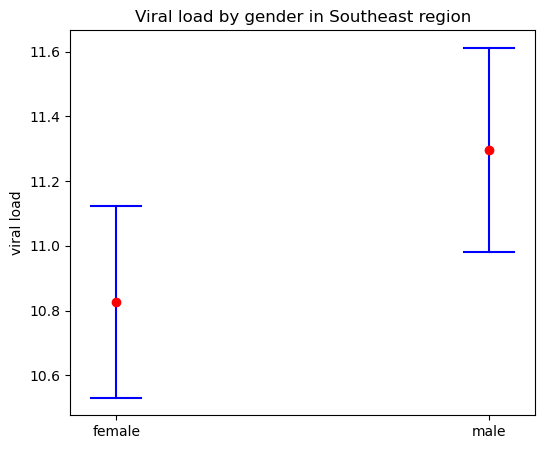

In [44]:
#Visualize influence
plt.figure(figsize=(6,5))
ax = plt.subplot()

ax.set_xticks([1, 2])
ax.set_xticklabels(['female', 'male'])
plot_conf_interval(1, southeast_adj[southeast_adj['sex']=='female']['viral_load'])
plot_conf_interval(2, southeast_adj[southeast_adj['sex']=='male']['viral_load'])

plt.ylabel('viral load')
plt.title('Viral load by gender in Southeast region')

plt.show()

Based on plot above, females have lower level of viral load than males in Southeast region.

### Viral load: Southwest <a id="southwest"></a>
In this section I applied multi-factors ANOVA to determine which factor influence on viral load in Southwest region.\
Factors (independent variables):
- sex
- age_category
- smoker

In [45]:
#Create condition for each group to further drop outliers
southwest_summary = southwest.groupby(['age_category', 'sex', 'smoker'])\
    .agg({'age': 'count', 'viral_load': ['mean', 'std']}).reset_index()

#Rename columns after grouping
southwest_summary.columns = ['age_category', 'sex', 'smoker', 'count', 'mean_viral_load', 'std_viral_load']

southwest_summary

,age_category,sex,smoker,count,mean_viral_load,std_viral_load
0,18-29,female,no,40,9.339750,1.983868
1,18-29,female,yes,8,9.476250,1.542622
2,18-29,male,no,38,9.678684,2.060448
3,18-29,male,yes,13,10.948462,1.356207
4,30-39,female,no,26,10.189231,1.652818
5,30-39,female,yes,6,10.078333,3.546826
6,30-39,male,no,20,10.605000,1.719396
7,30-39,male,yes,12,10.221667,1.893946
8,40-49,female,no,31,9.862581,1.409184
9,40-49,female,yes,2,10.215000,1.859691


In [46]:
#Apply Normality Test function (which created above)
#Exclude 40-49 female smoker group deu to there are only two observations
normality_test(southwest_summary[southwest_summary['count']>2], southwest)

0.6751191020011902
0.3096294403076172
0.1921713650226593
0.34363049268722534
0.9002782702445984
0.6534984111785889
0.06465660035610199
0.4405031204223633
0.9523471593856812
0.7234596014022827
0.34212571382522583
0.6859261393547058
0.9662207961082458
0.028688883408904076
0.7340384125709534


In [47]:
#Create condition for each group to further drop outliers and exclude too small sample

#40-49 female smoker
sw_1 = (southwest['age_category'] == '40-49') \
          & (southwest['sex'] == 'female') \
          & (southwest['smoker'] == 'yes')

#50-64 male not smoker outliers
sw_2 = (southwest['age_category'] == '50-64') \
          & (southwest['sex'] == 'male') \
          & (southwest['smoker'] == 'no') \
          & (southwest['viral_load'] < 8)

#Drop rows according to the conditions and create new DataFrame
southwest_adj = southwest.drop(southwest[sw_1 | sw_2].index)

In [48]:
#50-64 male no smoker group
sw_2_adj = stats.shapiro(southwest_adj[(southwest_adj['age_category'] == '50-64')
                                         & (southwest_adj['sex'] == 'male')
                                         & (southwest_adj['smoker'] == 'no')]['viral_load'])

print(f'Group 1: {sw_2_adj}')

Group 1: ShapiroResult(statistic=0.9482507109642029, pvalue=0.09212033450603485)


p > 0.05, means data is normally distributed now.

In [49]:
#Apply Homoscedasticity Test function (which created above)
homos_test(southwest_summary[(southwest_summary['count']>2)], southwest_adj)

LeveneResult(statistic=2.2091838404359634, pvalue=0.007576415406272214)

p-value < 0.05, means that treams of homoscedasticity isn't met.\
30-39 female smoker group has extreme big std (3.54) then other groups, let's exclude it from analysis.

In [50]:
#Create adjusted summary table
southwest_summary_adj = southwest_summary[(southwest_summary['count'] > 2) & ~(southwest_summary['std_viral_load'] > 3.5)]

In [51]:
#Apply Homoscedasticity Test again with adjusted data
homos_test(southwest_summary_adj, southwest_adj)

LeveneResult(statistic=1.630369718973062, pvalue=0.07598825188144835)

p-value > 0.05, means terms about homoscedasticity are met. Now, we can perform multi-factor ANOVA.

In [52]:
# Adjusted again, drop 30-39 female smoker group
sw_3 = (southwest_adj['age_category'] == '30-39') \
          & (southwest_adj['sex'] == 'female') \
          & (southwest_adj['smoker'] == 'yes')

southwest_adj = southwest_adj.drop(southwest_adj[sw_3].index)

In [53]:
#ANOVA performing
model_southwest = ols('''viral_load ~ C(age_category) + C(sex) + C(smoker) +
                         C(age_category):C(sex) + C(age_category):C(smoker) + C(sex):C(smoker) +
                         C(age_category):C(sex):C(smoker)''', data=southwest_adj).fit()
#Test results
sm.stats.anova_lm(model_southwest, typ=2)

C:\Users\vadim\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(age_category),97.541654,3.0,10.570701,0.000001
C(sex),18.804426,1.0,6.113572,0.013975
C(smoker),1.320024,1.0,0.429157,0.512910
C(age_category):C(sex),6.396228,3.0,0.693167,0.556837
C(age_category):C(smoker),1.931260,3.0,0.209293,0.647657
C(sex):C(smoker),0.014117,1.0,0.004589,0.946034
C(age_category):C(sex):C(smoker),16.876938,3.0,1.828973,0.141906
Residual,913.527276,297.0,NaN,NaN


Based on the ANOVA results, only 'age_category' significantly influence on viral load as well as 'sex' in Southeast region.

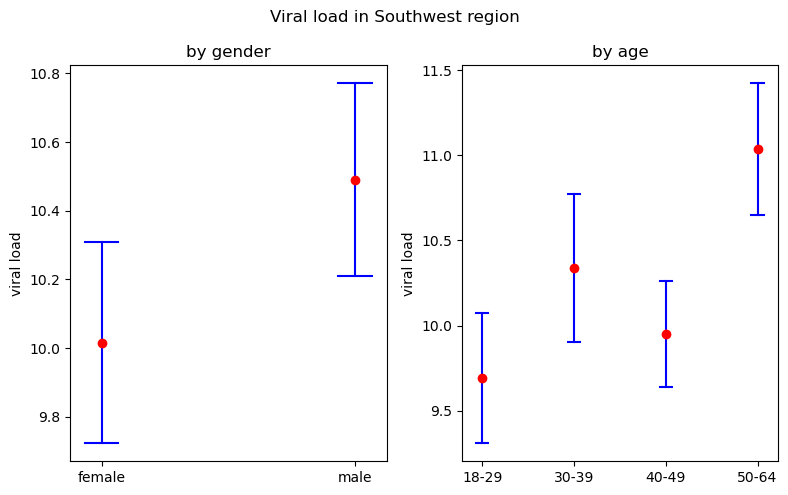

In [54]:
#Visualize influence factors
plt.figure(figsize=(8,5))

plt.suptitle('Viral load in Southwest region')

#Plot by gender
ax1 = plt.subplot(1,2,1)

ax1.set_xticks([1, 2])
ax1.set_xticklabels(['female', 'male'])
plot_conf_interval(1, southwest_adj[southwest_adj['sex']=='female']['viral_load'])
plot_conf_interval(2, southwest_adj[southwest_adj['sex']=='male']['viral_load'])

plt.ylabel('viral load')
plt.title('by gender')

#Plot by ages
ax2 = plt.subplot(1,2,2)

ax2.set_xticks([1, 2, 3, 4])
ax2.set_xticklabels(['18-29', '30-39', '40-49', '50-64'])

plot_conf_interval(1, southwest_adj[southwest_adj['age_category']=='18-29']['viral_load'])
plot_conf_interval(2, southwest_adj[southwest_adj['age_category']=='30-39']['viral_load'])
plot_conf_interval(3, southwest_adj[southwest_adj['age_category']=='40-49']['viral_load'])
plot_conf_interval(4, southwest_adj[southwest_adj['age_category']=='50-64']['viral_load'])

plt.ylabel('viral load')
plt.title('by age')

plt.tight_layout()
plt.show()

According to plots above, in Southwest region females have lower level of viral load than males as well as younger people.

### Viral load: Summary

Factor age has a significant effect on viral load In Northeast and Southwest regions, meaning older patients have higher viral load of COVID in blood.

Factor gender has a significant influence too. In the Northeast region females have higher viral load meanwhile there is the opposite situation in Southeast and Southwest regions - males have a higher this indicator.

And only in the Northwest region, no factor has a significant impact on viral load. Cause of this can be the impact of another factor that isn’t present in the dataset (vaccination status, time since infection, etc.)

## Impact on hospitalization charges <a id="hosp_impact"></a>
In this section I explored what independent variables impact on hospitalization charges.

In [55]:
#Keep only interested fields
hosp_charges = data[['smoker', 'viral_load', 'severity_level', 'age', 'hospitalization_charges']]

Explore correlation between 'viral_load' and 'hospitalization_charges'. As both variables are numerical, I used regression analysis:

In [56]:
#Devide variables
X = hosp_charges['viral_load']  # Independent variables
y = hosp_charges['hospitalization_charges']  # Dependent variable

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     hospitalization_charges   R-squared:                       0.039
Model:                                 OLS   Adj. R-squared:                  0.039
Method:                      Least Squares   F-statistic:                     54.74
Date:                     Sat, 22 Jul 2023   Prob (F-statistic):           2.43e-13
Time:                             14:34:20   Log-Likelihood:                -15677.
No. Observations:                     1338   AIC:                         3.136e+04
Df Residuals:                         1336   BIC:                         3.137e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

According to model result, 'viral_load' describe only 3.9% of 'hospitalization_charges' variance due to small positive correlation (0.198).

Let's add 'age' variable to the model which has 0.3 correlation coef.

In [57]:
factors = sm.add_constant(hosp_charges[['viral_load', 'age']])

model_2_factors = sm.OLS(y, factors)
res_2_factors = model_2_factors.fit()

print(res_2_factors.summary())

                               OLS Regression Results                              
Dep. Variable:     hospitalization_charges   R-squared:                       0.117
Model:                                 OLS   Adj. R-squared:                  0.116
Method:                      Least Squares   F-statistic:                     88.61
Date:                     Sat, 22 Jul 2023   Prob (F-statistic):           7.32e-37
Time:                             14:34:20   Log-Likelihood:                -15620.
No. Observations:                     1338   AIC:                         3.125e+04
Df Residuals:                         1335   BIC:                         3.126e+04
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

R-squared became much higher 0.12, but it still to little. 88% of variance contingent on another factor. 

Explore how 'smoker' factor influence on 'hospitalization_charges':

In [58]:
#Look at overall statistics between smokers and no smokers
hosp_charges.groupby('smoker')['hospitalization_charges'].describe()

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1064.0,21085.675752,14984.455500,2805.0,9966.25,18363.5,28407.25,92277.0
yes,274.0,80125.572993,28853.891137,32074.0,52065.50,86141.0,102548.25,159426.0


As it's described on table above, mean and std are very different.
So, I'm confident that there is statistical difference between groups, but let's use T-test to check it out.

In [59]:
#Devide into two groups
smoker = hosp_charges[hosp_charges['smoker']=='yes']['hospitalization_charges']
non_smoker = hosp_charges[hosp_charges['smoker']=='no']['hospitalization_charges']


Build QQ plots to see how data distributed across groups

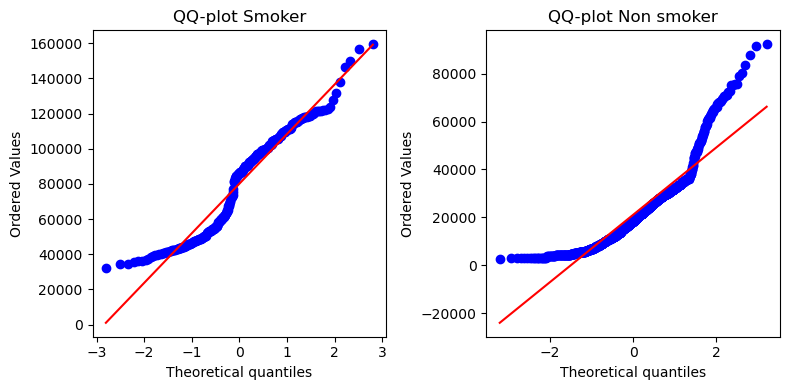

In [60]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

stats.probplot(smoker, dist='norm', plot=plt)
plt.title('QQ-plot Smoker')

plt.subplot(1, 2, 2)
stats.probplot(non_smoker, dist='norm', plot=plt)
plt.title('QQ-plot Non smoker')

plt.tight_layout()
plt.show()

Data isn't distributed in both groups. I transform values to log for each group: 

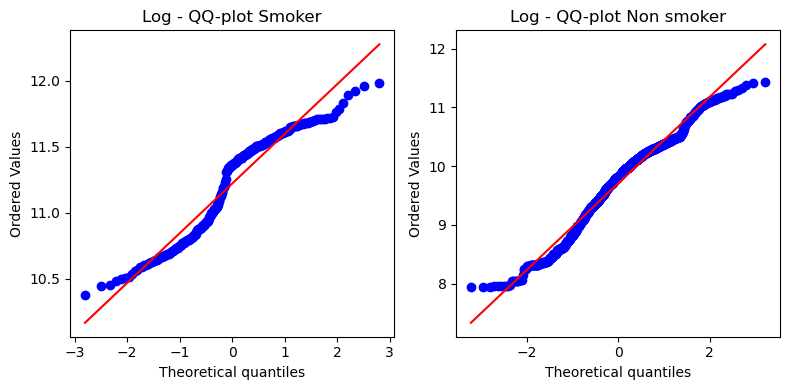

In [61]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

stats.probplot(np.log(smoker), dist='norm', plot=plt)
plt.title('Log - QQ-plot Smoker')

plt.subplot(1, 2, 2)
stats.probplot(np.log(non_smoker), dist='norm', plot=plt)
plt.title('Log - QQ-plot Non smoker')

plt.tight_layout()
plt.show()

Now values looks musch closer to normal distribution. Use T-test on log-transformed values:

In [62]:
stats.ttest_ind(np.log(smoker), np.log(non_smoker))

Ttest_indResult(statistic=32.59026445594537, pvalue=6.305159442198459e-172)

p-value < 0.05 - reject null hypothesis. There is significant difference in hospitalization costs between groups.

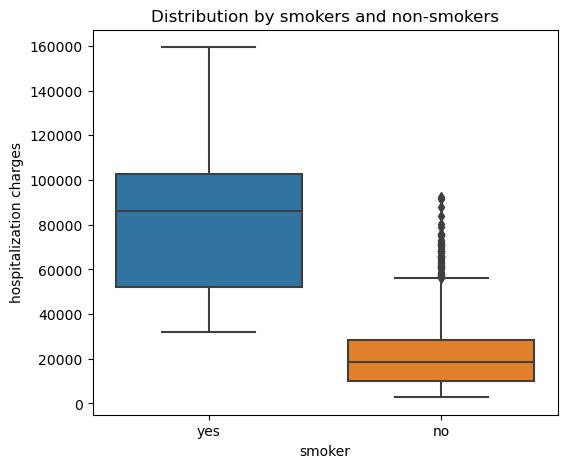

In [63]:
#Plot distributions of two samples
plt.figure(figsize=(6,5))
sns.boxplot(x='smoker', y='hospitalization_charges', data=hosp_charges)
plt.ylabel('hospitalization charges')
plt.title('Distribution by smokers and non-smokers')

plt.show()

According to the test results and visualization, smokers usually pay much higher for hospitalization than non-smokers.

Now, let's test how 'severity_level' influence on 'hospitalization_charges':

In [64]:
#Devide records by severity level (0-5)
lvl_0 = hosp_charges[hosp_charges['severity_level'] == 0]['hospitalization_charges']
lvl_1 = hosp_charges[hosp_charges['severity_level'] == 1]['hospitalization_charges']
lvl_2 = hosp_charges[hosp_charges['severity_level'] == 2]['hospitalization_charges']
lvl_3 = hosp_charges[hosp_charges['severity_level'] == 3]['hospitalization_charges']
lvl_4 = hosp_charges[hosp_charges['severity_level'] == 4]['hospitalization_charges']
lvl_5 = hosp_charges[hosp_charges['severity_level'] == 5]['hospitalization_charges']

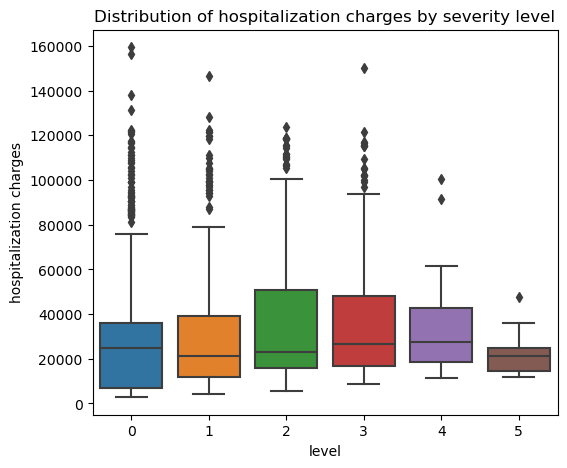

In [65]:
#Plot distribution of each severity level
plt.figure(figsize=(6,5))
sns.boxplot(x="severity_level", y="hospitalization_charges", data=hosp_charges)
plt.ylabel('hospitalization charges')
plt.xlabel('level')
plt.title('Distribution of hospitalization charges by severity level')

plt.show()

According to boxplots, each level distribution is skewed right and has outliers.
However, ANOVA requires normal distributions. To fix that let's drop outliers and logarithmize 'hospitalization charges' variable:

In [66]:
#Filter out outliers and apply natural logarithm for each group
lvl_0_adj = np.log(lvl_0[lvl_0<75000])
lvl_1_adj = np.log(lvl_1[lvl_1<80000])
lvl_2_adj = np.log(lvl_2[lvl_2<100000])
lvl_3_adj = np.log(lvl_3[lvl_3<90000])
lvl_4_adj = np.log(lvl_4[lvl_4<70000])
lvl_5_adj = np.log(lvl_5[lvl_5<40000])

#Perform 1-way ANOVA
res_lvl = stats.f_oneway(lvl_0_adj, lvl_1_adj, lvl_2_adj, lvl_3_adj, lvl_4_adj, lvl_5_adj)
res_lvl

F_onewayResult(statistic=14.95656548679584, pvalue=2.910403721194005e-14)

p-value < 0.05, means at least two groups are significant different from each other.\
Perform Tukey HSD test to find difference between each pair:

In [67]:
#Union all levels hospital charges values
group_lvl = np.concatenate([lvl_0_adj, lvl_1_adj, lvl_2_adj, lvl_3_adj, lvl_4_adj, lvl_5_adj])

#Add labels
labels_lvl = ['level 0'] * lvl_0_adj.shape[0] + ['level 1'] * lvl_1_adj.shape[0] \
               + ['level 2'] * lvl_2_adj.shape[0] + ['level 3'] * lvl_3_adj.shape[0] \
               + ['level 4'] * lvl_4_adj.shape[0] + ['level 5'] * lvl_5_adj.shape[0]

#Run Tukey test
tukey_res_lvl = pairwise_tukeyhsd(group_lvl, labels_lvl, alpha=0.05)

print(tukey_res_lvl)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
level 0 level 1    0.197 0.0076   0.034 0.3601   True
level 0 level 2   0.4354    0.0   0.256 0.6149   True
level 0 level 3   0.4723    0.0  0.2597 0.6849   True
level 0 level 4   0.5274 0.0189  0.0539  1.001   True
level 0 level 5   0.2233  0.854 -0.3244  0.771  False
level 1 level 2   0.2384 0.0083  0.0398  0.437   True
level 1 level 3   0.2753 0.0081  0.0463 0.5042   True
level 1 level 4   0.3304 0.3662 -0.1507 0.8115  False
level 1 level 5   0.0262    1.0  -0.528 0.5805  False
level 2 level 3   0.0369  0.998  -0.204 0.2778  False
level 2 level 4    0.092 0.9945 -0.3949 0.5789  False
level 2 level 5  -0.2121 0.8884 -0.7715 0.3472  False
level 3 level 4   0.0551 0.9996 -0.4449 0.5552  False
level 3 level 5   -0.249 0.8144 -0.8198 0.3218  False
level 4 level 5  -0.3041 0.8263 -1.0147 0.4064  False
----------------------------

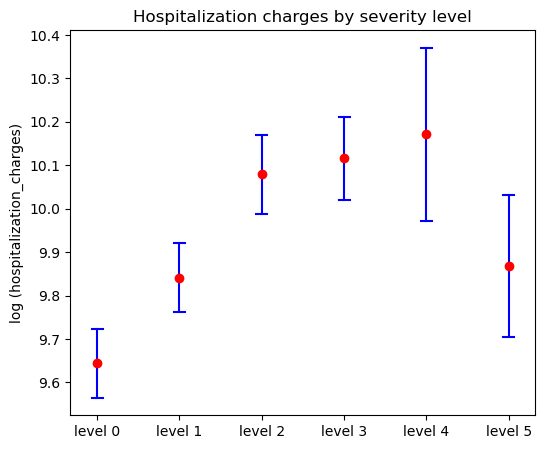

In [68]:
#Build confidence interval plot
plt.figure(figsize=(6,5))
ax = plt.subplot()
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['level 0', 'level 1', 'level 2', 'level 3', 'level 4', 'level 5'])
plot_conf_interval(0, lvl_0_adj)
plot_conf_interval(1, lvl_1_adj)
plot_conf_interval(2, lvl_2_adj)
plot_conf_interval(3, lvl_3_adj)
plot_conf_interval(4, lvl_4_adj)
plot_conf_interval(5, lvl_5_adj)

plt.ylabel('log (hospitalization_charges)')
plt.title('Hospitalization charges by severity level')

plt.show()

According to the table above, a statistically significant correlation was found between level of severity and hospitalization charges.
Specifically, patients with severity level 0 pay less than other level patients (except level 5 - no difference).
And only patients with severity level 2 and 3 pay more than patients with level 1. Hospitalization charges in level 4 patients and level 1 once isn't different.

### Impact on hospitalization charges: Summary

Viral load and age explain only 11.6% hospitalization costs variation. 

Smoking patients pay much higher than non-smoking patients (median: 86141 vs 18363).

Severity Level 0 and level 5 patients pay less (median: 24098). Hospitalization charges are higher for 2-4 severity level patients (median: 25372).